# Titanic - Machine Learning from Disaster
Author: *BHAVYAI GUPTA*


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We are going to follow the following workflow: Use the training portion to find the best model (optionally using grid search) and cross-validation. Evaluate the *winner* on the test set.

## 0. Function definitions

In [2]:
from sklearn.model_selection import cross_validate

def get_classifier_cv_score(model, X, y, scoring='accuracy', cv=7):
    '''Calculate train and validation scores of classifier (model) using cross-validation

        model (sklearn classifier): Classifier to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        scoring (str): a scoring string accepted by sklearn.metrics.cross_validate()
        cv (int): number of cross-validation folds see sklearn.metrics.cross_validate()

        returns: mean training score, mean validation score
    '''

    score = cross_validate(estimator=model, X=X, y=y,
                           cv=cv, scoring=scoring, return_train_score=True)
    score_train = score['train_score'].mean()
    score_test = score['test_score'].mean()

    return (score_train, score_test)

In [3]:
def print_grid_search_result(grid_search):
    '''Prints summary of best model from GridSearchCV object.
    
        For the best model of the grid search, print:
        - parameters 
        - cross-validation training score
        - cross-validation validation score 
        
        scores are printed with 3 decimal places.
    
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        returns: None
    '''
    
    print("Best parameters   = {}".format(grid_search.best_params_))
    print("CV Training Score = {:.3f}".format(grid_search.cv_results_['mean_train_score'].max()))
    print("CV Test Score     = {:.3f}".format(grid_search.cv_results_['mean_test_score'].max()))
    
    return None

In [4]:
import mglearn

def plot_grid_search_results(grid_search):
    '''For grids with 2 hyperparameters, create a heatmap plot of test scores
        
        grid_search (sklearn GridSearchCV): Fitted GridSearchCV object
        
        uses mglearn.tools.heatmap() for plotting.
    '''
    results = pd.DataFrame(grid_search.cv_results_)

    params = sorted(grid_search.param_grid.keys())
    
    assert len(params) == 2, "We can only plot two parameters."
    
    # second dimension in reshape are rows, needs to be the fast changing parameter
    scores = np.array(results.mean_test_score).reshape(len(grid_search.param_grid[params[0]]),
                                                      len(grid_search.param_grid[params[1]]))

    # plot the mean cross-validation scores
    # x-axis needs to be the fast changing parameter
    mglearn.tools.heatmap(scores, 
                          xlabel=params[1], 
                          xticklabels=grid_search.param_grid[params[1]], 
                          ylabel=params[0], 
                          yticklabels=grid_search.param_grid[params[0]],
                          cmap="viridis", fmt="%0.3f")

In [5]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_actual, y_pred, labels, title=''):
    '''Creates a heatmap plot of the confusion matrix.

        y_actual (pandas.DataSeries or numpy.Array): Ground truth label vector
        y_pred (pandas.DataSeries or numpy.Array): Predicted label vector
        labels (list(str)): Class names used for plotting (ticklabels)
        title (str): Plot title

        uses sklearn.metrics.confusion_matrix
    '''

    cm = confusion_matrix(y_actual, y_pred)
    sns.heatmap(data=cm, xticklabels=labels, yticklabels=labels, cbar=False, square=True, annot=True, fmt='g')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.title(title)

## 1. Load data

Titanic dataset is downloaded as csv files  
[https://www.kaggle.com/c/titanic/data](https://www.kaggle.com/c/titanic/data)

### 1.1 Prepare the feature matrix and target vector

Using the pandas `read_csv()` function, load the train data set into feature matrix `X` and target vector `y`.

Print shape and type of `X`, `y`.

In [6]:
dataset_train = pd.read_csv('dataset_train.csv')
dataset_test = pd.read_csv('dataset_test.csv')

X = dataset_train.drop(columns=['Survived'])
y = dataset_train['Survived']

print("Type of X = {}, Shape of X = {}".format(type(X), X.shape))
print("Type of y = {}, Shape of y = {}".format(type(X), y.shape))

Type of X = <class 'pandas.core.frame.DataFrame'>, Shape of X = (891, 11)
Type of y = <class 'pandas.core.frame.DataFrame'>, Shape of y = (891,)


## 2. Inspect the data 



### 2.1 What features we have in the data

In [7]:
X.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


First we drop non-categorial features that dont have any significance - like `PassengerId`, `Name`, and `Ticket`.

In [10]:
dataset_list = [X, dataset_test]

X.drop('PassengerId', axis=1, inplace=True)

for d in dataset_list:
    d.drop('Name', axis=1, inplace=True)
    d.drop('Ticket', axis=1, inplace=True)

There are lot of missing values in the column `cabin`. We simply drop this column

In [11]:
for d in dataset_list:
    d.drop('Cabin', axis=1, inplace=True)

We see missing values in the columns `Age` and `Embarked`. We fill missing values in `Age` with mean and `Embarked` with mode.

In [12]:
for d in dataset_list:
    d['Age'].fillna(d['Age'].mean(), inplace=True)
    d['Embarked'] = d['Embarked'].fillna(d['Embarked'].mode()[0])

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [14]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         417 non-null    float64
 7   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


We see a missing value in the columns `Fare`. We fill missing values with mean.

In [15]:
dataset_test['Fare'].fillna(dataset_test['Fare'].mean(), inplace=True)   

### 2.2 Relationship between features and target classes

To understand the relationship between categorical features and target classes better, it is usefull to produce barplots with bars for each target class. Using seaborn `countplot()`, produce a barplot for each of the categorial feature columns in `X` using  `y` as hue.

We have the below categorical features -
+ Pclass
+ Sex
+ SibSp
+ Parch
+ Embarked


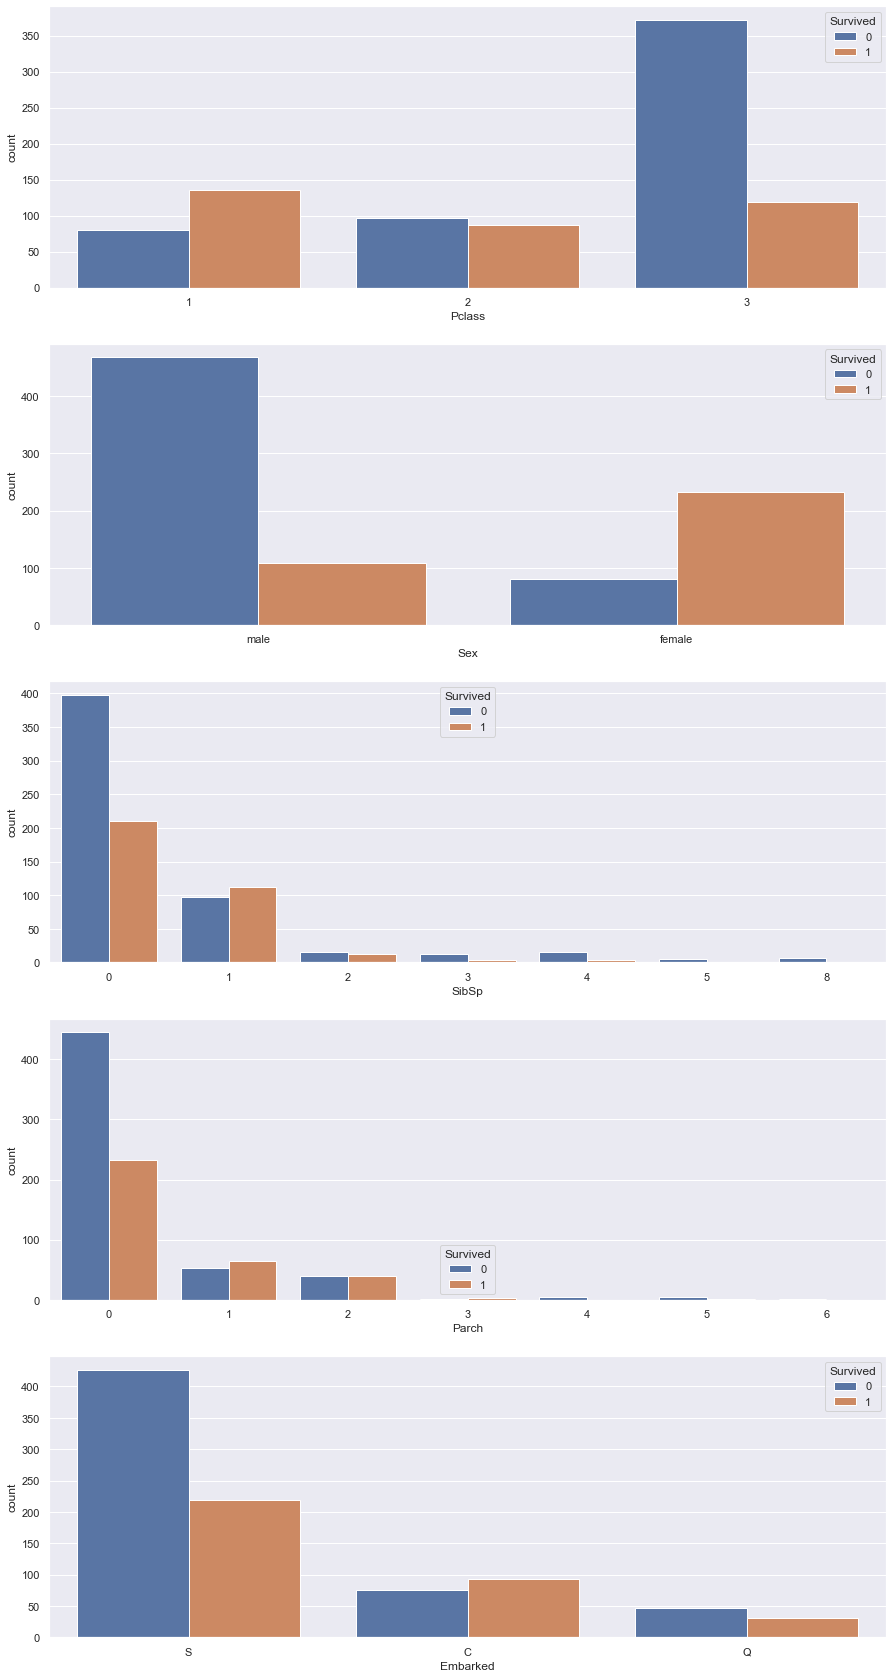

In [16]:
sns.set(rc={'figure.figsize':(15, 30)})
fig = plt.figure(1)
axs = fig.subplots(5, 1)

sns.countplot(data=X, hue=y, x="Pclass", ax=axs[0]);
sns.countplot(data=X, hue=y, x="Sex", ax=axs[1]);
sns.countplot(data=X, hue=y, x="SibSp", ax=axs[2]);
sns.countplot(data=X, hue=y, x="Parch", ax=axs[3]);
sns.countplot(data=X, hue=y, x="Embarked", ax=axs[4]);

## 3. Preprocessing

We map male to 0 and female to 1 in the `Sex` column

In [17]:
sex_mapping = {"male": 0, "female": 1}

for d in dataset_list:
    d['Sex'] = d['Sex'].map(sex_mapping)

In [18]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.000000,1,0,7.2500,S
1,1,1,38.000000,1,0,71.2833,C
2,3,1,26.000000,0,0,7.9250,S
3,1,1,35.000000,1,0,53.1000,S
4,3,0,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,0,27.000000,0,0,13.0000,S
887,1,1,19.000000,0,0,30.0000,S
888,3,1,29.699118,1,2,23.4500,S
889,1,0,26.000000,0,0,30.0000,C


We convert the numerical column `Age` to a categorial feature by creating age groups by binning

In [19]:
for d in dataset_list:
    d['Age'] = d['Age'].astype(int)
    
    d.loc[ d['Age'] <= 16, 'Age'] = 0
    d.loc[(d['Age'] > 16) & (d['Age'] <= 26), 'Age'] = 1
    d.loc[(d['Age'] > 26) & (d['Age'] <= 36), 'Age'] = 2
    d.loc[(d['Age'] > 36) & (d['Age'] <= 62), 'Age'] = 3
    d.loc[ d['Age'] > 62, 'Age'] = 4

In [20]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,1,1,0,7.2500,S
1,1,1,3,1,0,71.2833,C
2,3,1,1,0,0,7.9250,S
3,1,1,2,1,0,53.1000,S
4,3,0,2,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,0,2,0,0,13.0000,S
887,1,1,1,0,0,30.0000,S
888,3,1,2,1,2,23.4500,S
889,1,0,1,0,0,30.0000,C


We convert the numerical column `Fare` to a categorial feature by creating fare groups by binning

In [21]:
for d in dataset_list:
    d.loc[ d['Fare'] <= 17, 'Fare'] = 0
    d.loc[(d['Fare'] > 17) & (d['Fare'] <= 30), 'Fare'] = 1
    d.loc[(d['Fare'] > 30) & (d['Fare'] <= 100), 'Fare'] = 2
    d.loc[ d['Fare'] > 100, 'Fare'] = 3

In [22]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,1,1,0,0.0,S
1,1,1,3,1,0,2.0,C
2,3,1,1,0,0,0.0,S
3,1,1,2,1,0,2.0,S
4,3,0,2,0,0,0.0,S
...,...,...,...,...,...,...,...
886,2,0,2,0,0,0.0,S
887,1,1,1,0,0,1.0,S
888,3,1,2,1,2,1.0,S
889,1,0,1,0,0,1.0,C


We map values in column `Embarked` to numerical values

In [23]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}

for d in dataset_list:
    d['Embarked'] = d['Embarked'].map(embarked_mapping)

In [24]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,1,1,0,0.0,0
1,1,1,3,1,0,2.0,1
2,3,1,1,0,0,0.0,0
3,1,1,2,1,0,2.0,0
4,3,0,2,0,0,0.0,0
...,...,...,...,...,...,...,...
886,2,0,2,0,0,0.0,0
887,1,1,1,0,0,1.0,0
888,3,1,2,1,2,1.0,0
889,1,0,1,0,0,1.0,1


## 5. Compare models using cross-validation
Create a list containing a `LogisticRegression()`, `RandomForestClassifier(random_state=55)`, `GradientBoostingClassifier(random_state=56)`, `SVC()` objects.

Iterate this list, then:
- compute the **average precision** using `get_classifier_cv_score()` defined above, 
- rank the models based on validation **average precision** (best first),
- and print the ranked models training and validation scores with **3 decimal places**. 

Use training data and 7-fold cross-validation.

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# model list
model_list = [LogisticRegression(), RandomForestClassifier(random_state=55), GradientBoostingClassifier(random_state=56), SVC()]

result_list = []

# iterate over the models to get the train and test score and store in results list
for m in model_list:
    (score_train, score_test) = get_classifier_cv_score(m, X, y, scoring='average_precision')
    result_list.append((m.__class__.__name__, score_train, score_test))


# sort the list based on test score
result_list.sort(key = lambda item: item[2], reverse=True)

# print the header
print("+----------------------------+-------------+------------+")
print("| model name                 | train_score | test_score |")
print("+----------------------------+-------------+------------+")

# print the models
for r in result_list:
    print("| {:<26} | {:11.3f} | {:10.3f} |".format(r[0], r[1], r[2]))
print("+----------------------------+-------------+------------+")

+----------------------------+-------------+------------+
| model name                 | train_score | test_score |
+----------------------------+-------------+------------+
| GradientBoostingClassifier |       0.888 |      0.837 |
| LogisticRegression         |       0.825 |      0.819 |
| RandomForestClassifier     |       0.932 |      0.816 |
| SVC                        |       0.819 |      0.796 |
+----------------------------+-------------+------------+


## 6. Hyperparameter tuning using grid search 

The inital cross-validation above showed that GradientBoostingClassifier model might have merit.

Other models might also perform well if properly tuned.

Next, hyperparameters are tuned using grid search.

### 6.1 Gradient boosting classifier 
Perform grid search using `GridSearchCV` for the `GradientBoostingClassifier(max_depth=5, random_state=56)`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'n_estimators': [50, 100, 200]`,
- `'learning_rate': [0.001, 0.01, 0.1, 1.0]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [26]:
from sklearn.model_selection import GridSearchCV

# create the parameter grid
param_grid_gbt = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1.0]
}

# setup the grid search
grid_gbt = GridSearchCV(GradientBoostingClassifier(max_depth=5, random_state=56), param_grid_gbt,
                        n_jobs=4, cv=7, scoring='average_precision', return_train_score=True)

In [27]:
# perform the grid search
grid_gbt.fit(X, y)

GridSearchCV(cv=7,
             estimator=GradientBoostingClassifier(max_depth=5, random_state=56),
             n_jobs=4,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='average_precision')

In [28]:
# print the grid search results
print_grid_search_result(grid_gbt)

Best parameters   = {'learning_rate': 0.01, 'n_estimators': 200}
CV Training Score = 0.938
CV Test Score     = 0.839


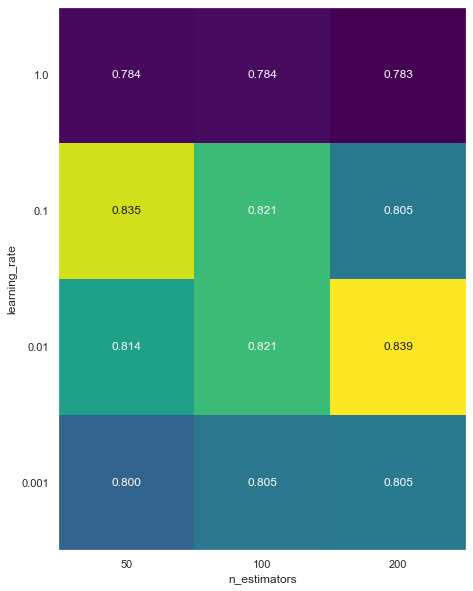

In [29]:
# plot validation metrics for all hyperparameter combinations
sns.set(rc={'figure.figsize':(10, 10)})
plot_grid_search_results(grid_gbt);

### 6.2 Logistic Regression  
Perform grid search using `GridSearchCV` for the `LogisticRegression()`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'n_estimators': [50, 100, 200]`,
- `'learning_rate': [0.001, 0.01, 0.1, 1.0]`
- `'C': [0.001, 0.01, 0.1, 1, 10]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [30]:
# create the parameter grid
param_grid_log = {
    'C': [0.001, 0.01, 0.1, 1, 10]
}

# setup the grid search
grid_log = GridSearchCV(LogisticRegression(), param_grid_log,
                        n_jobs=4, cv=7, scoring='average_precision', return_train_score=True)

In [31]:
# perform the grid search
grid_log.fit(X, y)

GridSearchCV(cv=7, estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             return_train_score=True, scoring='average_precision')

In [32]:
# print the grid search results
print_grid_search_result(grid_log)

Best parameters   = {'C': 1}
CV Training Score = 0.825
CV Test Score     = 0.819


### 6.3 SVC grid search
Perform grid search using `GridSearchCV` for the `SVC()`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'C': [0.0001, 0.001, 0.01, 0.1]`
- `'gamma': [0.1, 1, 10, 100]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [33]:
# create the parameter grid
param_grid_svc = {
    'C': [0.0001, 0.001, 0.01, 0.1],
    'gamma': [0.1, 1, 10, 100]
}

# setup the grid search
grid_svc = GridSearchCV(SVC(), param_grid_svc,
                        n_jobs=4, cv=7, scoring='average_precision', return_train_score=True)

In [34]:
# perform the grid search
grid_svc.fit(X, y)

GridSearchCV(cv=7, estimator=SVC(), n_jobs=4,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1],
                         'gamma': [0.1, 1, 10, 100]},
             return_train_score=True, scoring='average_precision')

In [35]:
# print the grid search results
print_grid_search_result(grid_svc)

Best parameters   = {'C': 0.1, 'gamma': 0.1}
CV Training Score = 0.867
CV Test Score     = 0.817


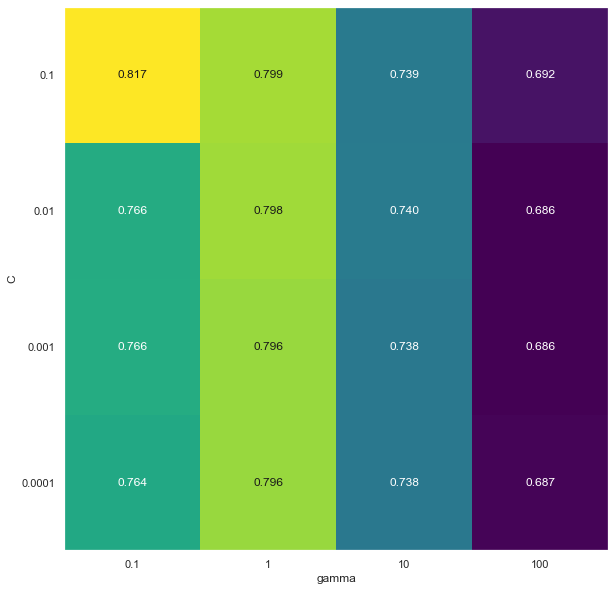

In [36]:
# plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_svc);

### 6.4 Grid search for RandomForestClassifier 

Perform grid search using `GridSearchCV` for the `RandomForestClassifier(random_state=55)`.

Grid search to use 7-fold cross-validation, and `average_precision` as the scoring function. Note that there is a `n_jobs` parameter to run search in parallel. Setting it to the number of CPU cores works well.

Use the following hyperparameters and values:
- `'n_estimators': [300, 500, 700, 1000]`
- `'max_depth': [7, 9, 11, 13]`

Use `print_grid_search_result()` and `plot_grid_search_result()` functions defined above to show the results.

In [37]:
# create the parameter grid
param_grid_rfc = {
    'n_estimators': [300, 500, 700, 1000],
    'max_depth': [7, 9, 11, 13]
}

# setup the grid search
grid_rfc = GridSearchCV(RandomForestClassifier(random_state=55), param_grid_rfc,
                        n_jobs=4, cv=7, scoring='average_precision', return_train_score=True)

In [38]:
# perform the grid search
grid_rfc.fit(X, y)

GridSearchCV(cv=7, estimator=RandomForestClassifier(random_state=55), n_jobs=4,
             param_grid={'max_depth': [7, 9, 11, 13],
                         'n_estimators': [300, 500, 700, 1000]},
             return_train_score=True, scoring='average_precision')

In [39]:
# print the grid search results
print_grid_search_result(grid_rfc)

Best parameters   = {'max_depth': 7, 'n_estimators': 300}
CV Training Score = 0.932
CV Test Score     = 0.842


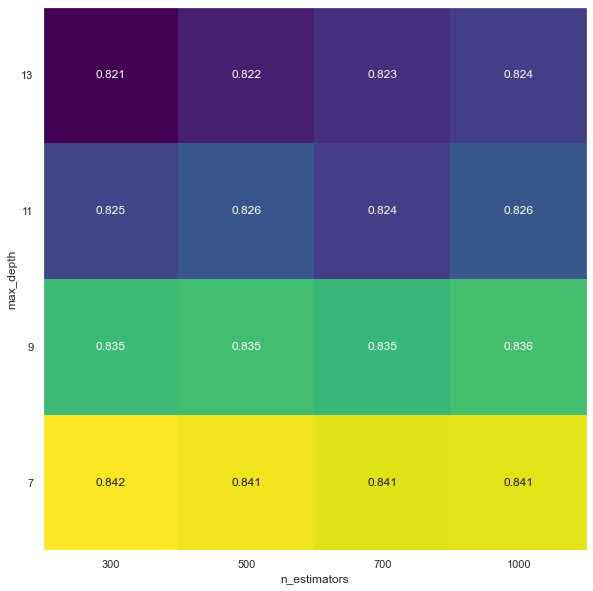

In [40]:
# plot validation metrics for all hyperparameter combinations
plot_grid_search_results(grid_rfc);

### *Question 2:* What are the training and validation scores of the three tuned (best) models? Summarize the results here.

Summary of results -

**GradientBoostingClassifier**  
CV Training Score = 0.938  
CV Test Score     = 0.839  

**LogisticRegression**  
CV Training Score = 0.825  
CV Test Score     = 0.819  

**SVC**  
CV Training Score = 0.867  
CV Test Score     = 0.817  

**RandomForestClassifier**  
CV Training Score = 0.932  
CV Test Score     = 0.842  

## 8. Retrain best model
Retrain the best `RandomForestClassifier()` from the grid search above on the training dataset.

In [41]:
# retrain random forest classifier on whole training data
best_model = grid_rfc.best_estimator_
best_model.fit(X, y)

RandomForestClassifier(max_depth=7, n_estimators=300, random_state=55)

## 9. Evaluate on test data

Using the retrained model, predict the test dataset and submit the results on Kaggle.

### 9.1 Evaluation

In [42]:
dataset_test_without_passengerid = dataset_test.drop("PassengerId", axis=1).copy()

y_pred = best_model.predict(dataset_test_without_passengerid)

In [43]:
prediction_df = pd.DataFrame({
    "PassengerId": dataset_test["PassengerId"],
    "Survived": y_pred
    })

# save the predictions to csv for submission
prediction_df.to_csv('predictions.csv', index=False)